In [65]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV,KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneOut
from sklearn import set_config
from sklearn.preprocessing import PolynomialFeatures
from sklearn.inspection import permutation_importance
set_config(display="diagram")
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

## Load the Data

In [66]:
car_value = pd.read_csv('data/vehicles.csv')

## Data Understanding

In [67]:
### Data overview
car_value

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,7301591192,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,1N4AA6AV6KC367801,fwd,NaN,sedan,NaN,wy
426876,7301591187,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,other,7JR102FKXLG042696,fwd,NaN,sedan,red,wy
426877,7301591147,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,other,1GYFZFR46LF088296,NaN,NaN,hatchback,white,wy
426878,7301591140,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,58ABK1GG4JU103853,fwd,NaN,sedan,silver,wy


In [68]:
car_value.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

### Interpretations:
1. Following columns may not be required in the final dataset: id,region, model,VIN
2. Model needs to be split to separate out type of car and doors
3. Year is null on some records - how to fill it?
4. Check for duplicates on VIN, once deduped this column is not required
5. Can we keep one of them region or State?
6. Size value is null - need to check details
7. Convert year and odometer to integer
8. Many columns have null values - need to have a strategy to address

In [69]:
### Exploration and running stats
print(car_value.describe())
print(car_value.describe(include=['object']))

                 id         price           year      odometer
count  4.268800e+05  4.268800e+05  425675.000000  4.224800e+05
mean   7.311487e+09  7.519903e+04    2011.235191  9.804333e+04
std    4.473170e+06  1.218228e+07       9.452120  2.138815e+05
min    7.207408e+09  0.000000e+00    1900.000000  0.000000e+00
25%    7.308143e+09  5.900000e+03    2008.000000  3.770400e+04
50%    7.312621e+09  1.395000e+04    2013.000000  8.554800e+04
75%    7.315254e+09  2.648575e+04    2017.000000  1.335425e+05
max    7.317101e+09  3.736929e+09    2022.000000  1.000000e+07
          region manufacturer   model condition    cylinders    fuel   
count     426880       409234  421603    252776       249202  423867  \
unique       404           42   29649         6            8       5   
top     columbus         ford   f-150      good  6 cylinders     gas   
freq        3608        70985    8009    121456        94169  356209   

       title_status transmission                VIN   drive       size  

### Interpretations:
1. Definitely looks like we have duplicates as the unique VIN numbers are for 50% of the cars that have VIN number.
2. We have some cars that do not have any price or odometer readings
3. We will keep the state and region value as we would not know from region what state it could be part of.

# Data Cleaning and Preparation

## Use known values from data set to populate missing values

In [70]:
car_value_model = car_value
#Use the model-manufacturer data in the dataset to populate the missing manufacturer,cylinders,fuel, transmission, drive
# size and type
car_value_model['manufacturer'] = car_value_model.sort_values(by='model')['manufacturer'].ffill()
car_value_model['cylinders'] = car_value_model.sort_values(by=['model','manufacturer'])['cylinders'].ffill()
car_value_model['fuel'] = car_value_model.sort_values(by=['model','manufacturer'])['fuel'].ffill()
car_value_model['transmission'] = car_value_model.sort_values(by=['model','manufacturer'])['transmission'].ffill()
car_value_model['drive'] = car_value_model.sort_values(by=['model','manufacturer'])['drive'].ffill()
car_value_model['size'] = car_value_model.sort_values(by=['model','manufacturer'])['size'].ffill()
car_value_model['type'] = car_value_model.sort_values(by=['model','manufacturer'])['type'].ffill()
#Finally populate the missing model based on the manufacturer, cylinders,drive,size and type
car_value_model['model'] = car_value_model.sort_values(by=['cylinders','manufacturer', 'drive', 'size','type'])['model'].ffill()

## Use Linear Regression model to predict missing fields based on the price 

In [71]:
# Function to take in the missing field to be predicted, field to use for prediction and the dataframe 
def predictValues(column_name_fill, column_name_predict, df):     
    # Check if DataFrame or column names are None
    if df is None or column_name_fill is None or column_name_predict is None:
        raise ValueError("DataFrame or column names cannot be None.")
    
    # Check if the columns exist in the DataFrame
    if column_name_fill not in df.columns or column_name_predict not in df.columns:
        raise ValueError(f"Columns {column_name_fill} or {column_name_predict} do not exist in the DataFrame.")
    
    # Use Categorical endoding for the column with missing values
    column_code= column_name_fill+"_code"
    df[column_code] = pd.Categorical(df[column_name_fill]).codes
    # Create map to later on reverse the Categorical encoding
    condition_map = dict(enumerate(pd.Categorical(df[column_name_fill]).categories))
    
    #Train set containing rows with the column to be predicted having values
    train_df = df[df[column_name_fill].notna()]
    #Test set containing rows with the column to be predicted empty
    test_df = df[df[column_name_fill].isna()]
    
    #Use Linear Regression model
    model = LinearRegression()
    #Use the train data - column used for prediction and the column to be predicted - for training the model
    model.fit(train_df[[column_name_predict]], train_df[column_code])
    
    #Use the column used to predict the missing values in the train set and use the condition map to replace the missing value
    predictions = model.predict(test_df[[column_name_predict]])
    predicted_codes = np.clip(np.round(predictions), 0, len(condition_map) - 1).astype(int)
    predicted_series = pd.Series(predicted_codes, index=test_df.index)
    df.loc[df[column_name_fill].isna(),column_name_fill] = predicted_series.map(condition_map)

    return df

In [72]:
# Populate the condition, title_status, year, pain_color and odometer reading based on Linear regression model based on the car price
car_value = predictValues('condition','price',car_value)
car_value = predictValues('title_status','price',car_value)
car_value = predictValues('year','price',car_value)
car_value = predictValues('paint_color','price',car_value)
car_value = predictValues('odometer','price',car_value)

In [73]:
#Now lets separate the cars with no VIN and the ones with VIN so that we can dedupe the data.
car_value_model_nullVIN = car_value_model[car_value_model['VIN'].isna()]
#Select the first record if there are duplicates based on the VIN #
car_value_model_uniqueVIN = car_value_model[car_value_model['VIN'].notna()].drop_duplicates(subset='VIN', keep="first")
#concatenate the data with null VIN and the deduped VIN
car_value = pd.concat([car_value_model_nullVIN,car_value_model_uniqueVIN])

In [74]:
#Finally drop values that we do not need
car_value.drop(['id','VIN','title_status_code','condition_code','paint_color_code','odometer_code','year_code','region','model'], axis=1, inplace=True)
#Convert the year to integer data type
car_value['year'] = car_value['year'].astype(int)

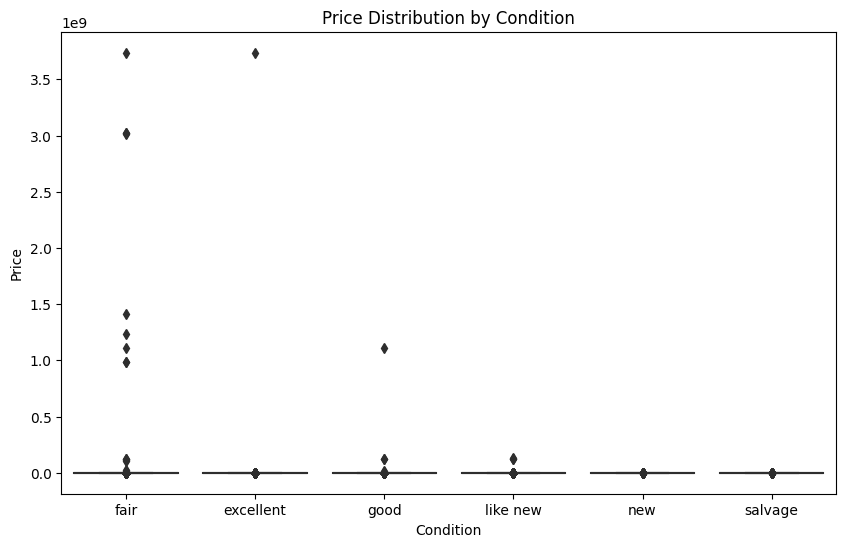

In [83]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=car_value, y="price", x='condition', palette='flare') 
plt.title('Price Distribution by Condition')
plt.xlabel('Condition')
plt.ylabel('Price')
plt.show()

### Interpretation
From above graph it looks like we have price outliers like 0 and in biliions, those should be removed from the dataset

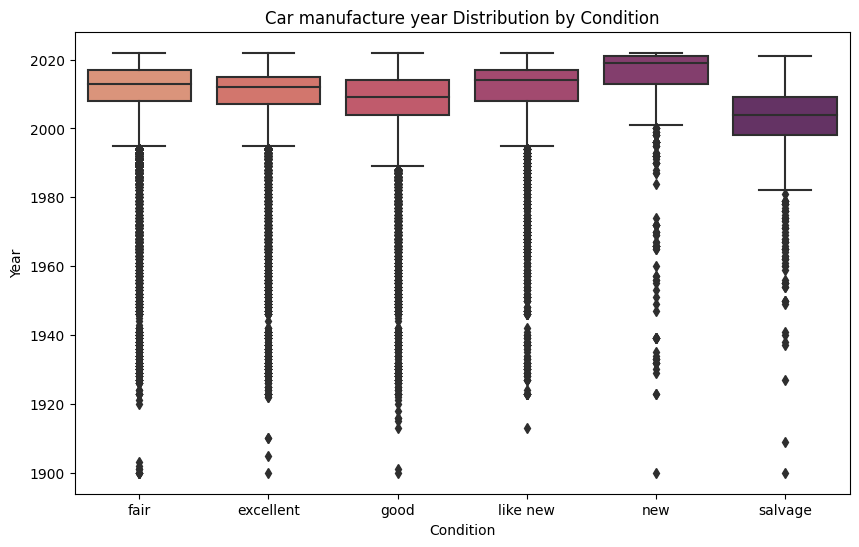

In [84]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=car_value, y="year", x='condition', palette='flare') 
plt.title('Car manufacture year Distribution by Condition')
plt.xlabel('Condition')
plt.ylabel('Year')
plt.show()

### Interpretation
From above graph looks like we have many outliers with older cars, we can remove those before 1920

In [85]:
# Based on the plots - remove the outliers and  consider the cars between the price range >0 and 300K and the year >1920
car_value = car_value.query('price > 0 & price < 300000')
car_value = car_value.query('year >1920')

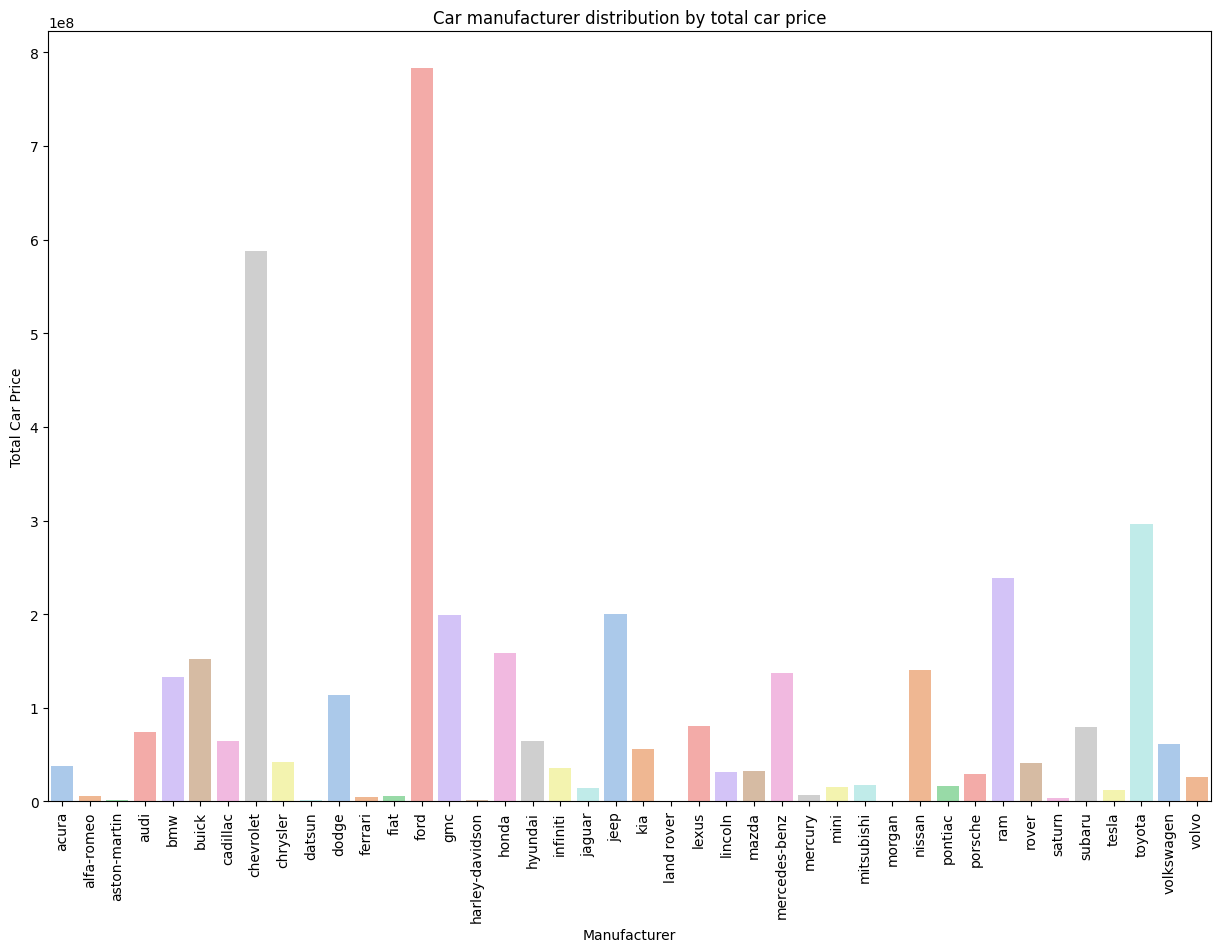

In [88]:
plt.figure(figsize=(15,10))
sns.barplot(data = (car_value.groupby("manufacturer")['price'].sum()).reset_index(), x="manufacturer", y="price", palette = "pastel")
plt.title('Car manufacturer distribution by total car price')
plt.xlabel('Manufacturer')
plt.ylabel('Total Car Price')
plt.xticks(rotation=90)
plt.show()

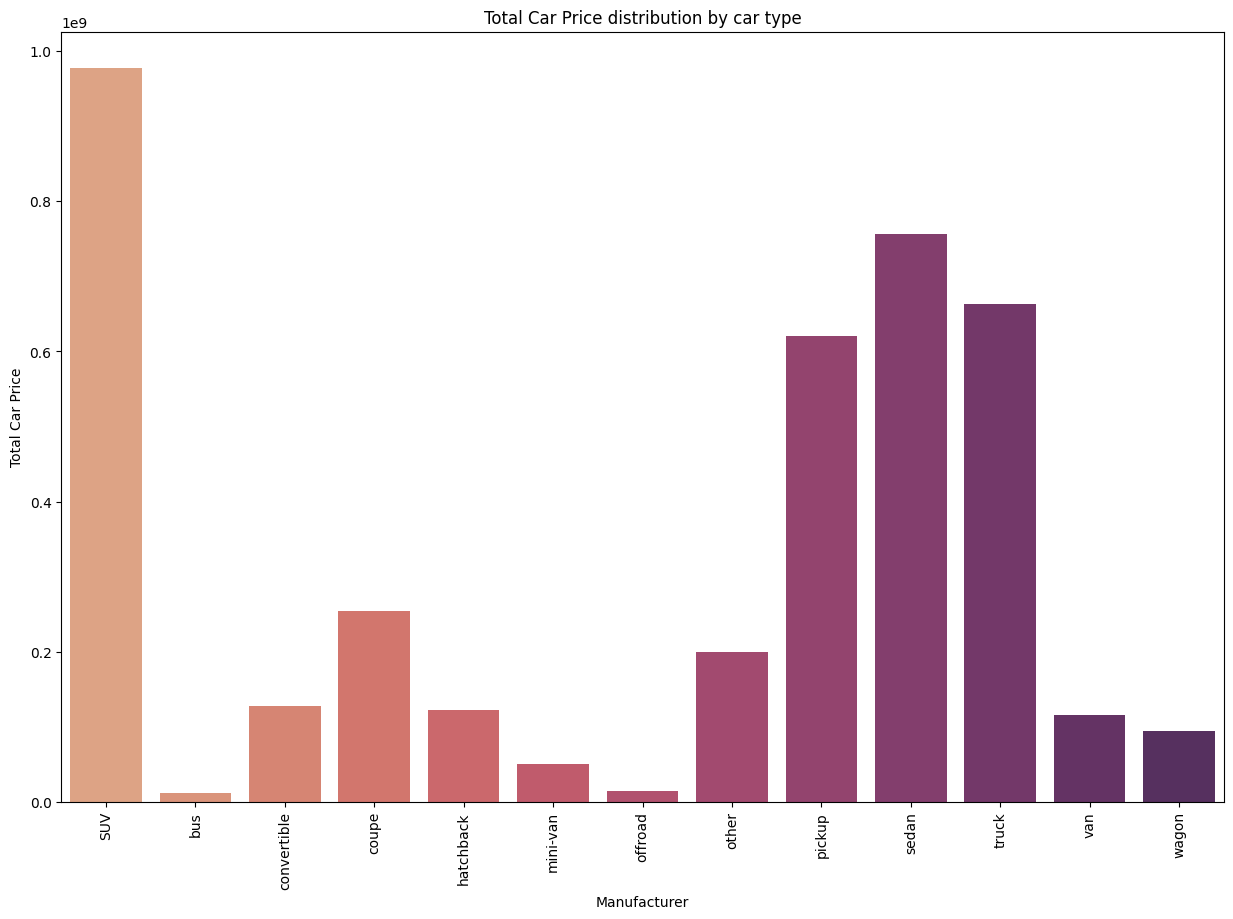

In [90]:
plt.figure(figsize=(15,10))
sns.barplot(data = (car_value.groupby("type")['price'].sum()).reset_index(), x="type", y="price", palette = "flare")
plt.title('Total Car Price distribution by car type')
plt.xlabel('Manufacturer')
plt.ylabel('Total Car Price')
plt.xticks(rotation=90)
plt.show()

## Interpretation
We can consolidate the car types

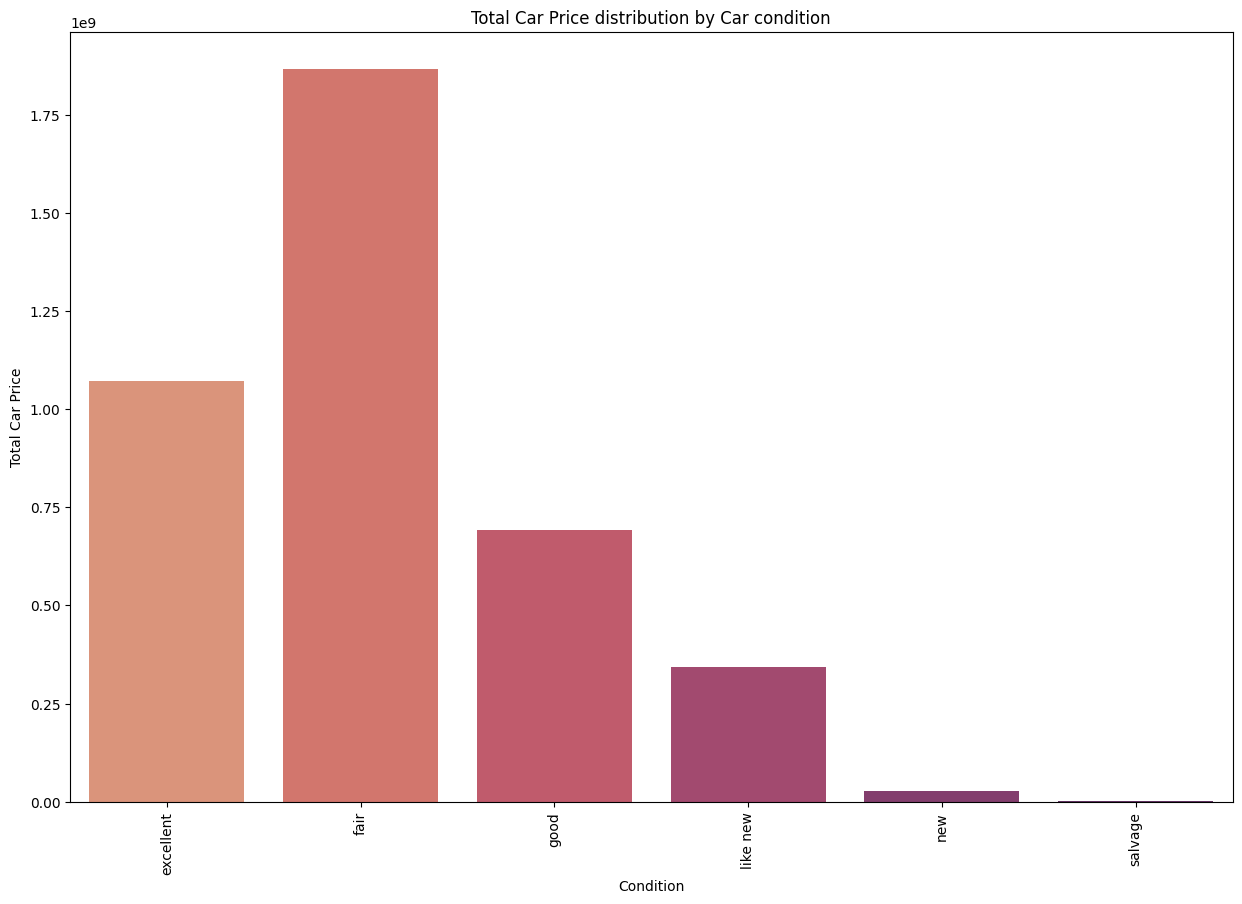

In [94]:
plt.figure(figsize=(15,10))
sns.barplot(data = (car_value.groupby("condition")['price'].sum()).reset_index(), x="condition", y="price", palette = "flare")
plt.title('Total Car Price distribution by Car condition')
plt.xlabel('Condition')
plt.ylabel('Total Car Price')
plt.xticks(rotation=90)
plt.show()
#fig = px.bar((car_value.query('condition == "salvage"').groupby("condition")['price'].sum()).reset_index(), x="condition", y="price")
#fig.show()

### Interpretation
We can remove the salvage cars from the dataset

In [96]:
#Consolidate the car types in to a broader category
car_value['type'].replace(['SUV','offroad','pickup','truck'], 'Utility_Vehicle', inplace=True)
car_value['type'].replace(['sedan','coupe','hatchback'], 'Passenger_Vehicle', inplace=True)
car_value['type'].replace(['mini-van','van','wagon'], 'Vans_Wagons', inplace=True)
car_value['type'].replace(['convertible','coupe'], 'Sporty_Cars', inplace=True)
car_value['type'].replace(['bus'], 'other', inplace=True)

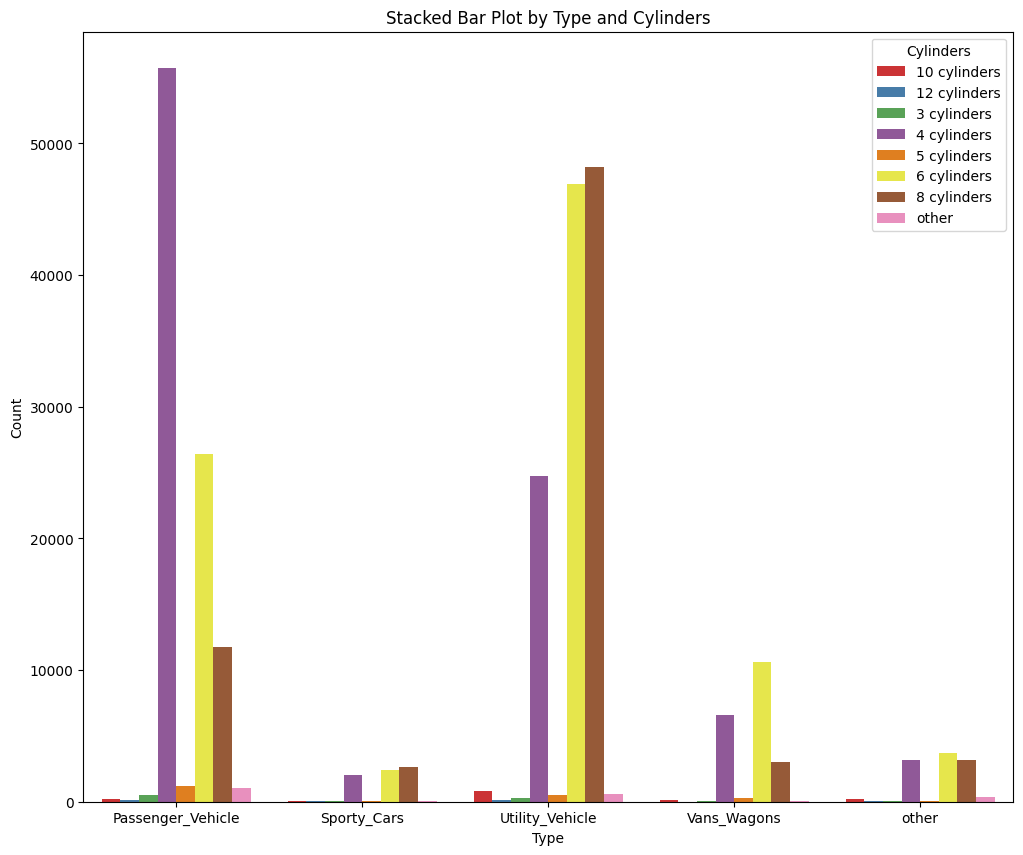

In [99]:
grouped_df = car_value.groupby(['type', 'cylinders']).size().unstack().fillna(0)

# Convert the grouped DataFrame to long format for Seaborn
long_df = grouped_df.reset_index().melt(id_vars='type', var_name='cylinders', value_name='count')

# Create a stacked bar plot with Seaborn
plt.figure(figsize=(12, 10))
sns.barplot(data=long_df, x='type', y='count', hue='cylinders', estimator=sum, palette='Set1')

plt.legend(title='Cylinders')
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Bar Plot by Type and Cylinders')
plt.show()
#car_value.groupby(['type','cylinders']).size().unstack().plot.bar(stacked=True, figsize=(12, 10))


### Interpretation 
We can consolidate the cylinder types

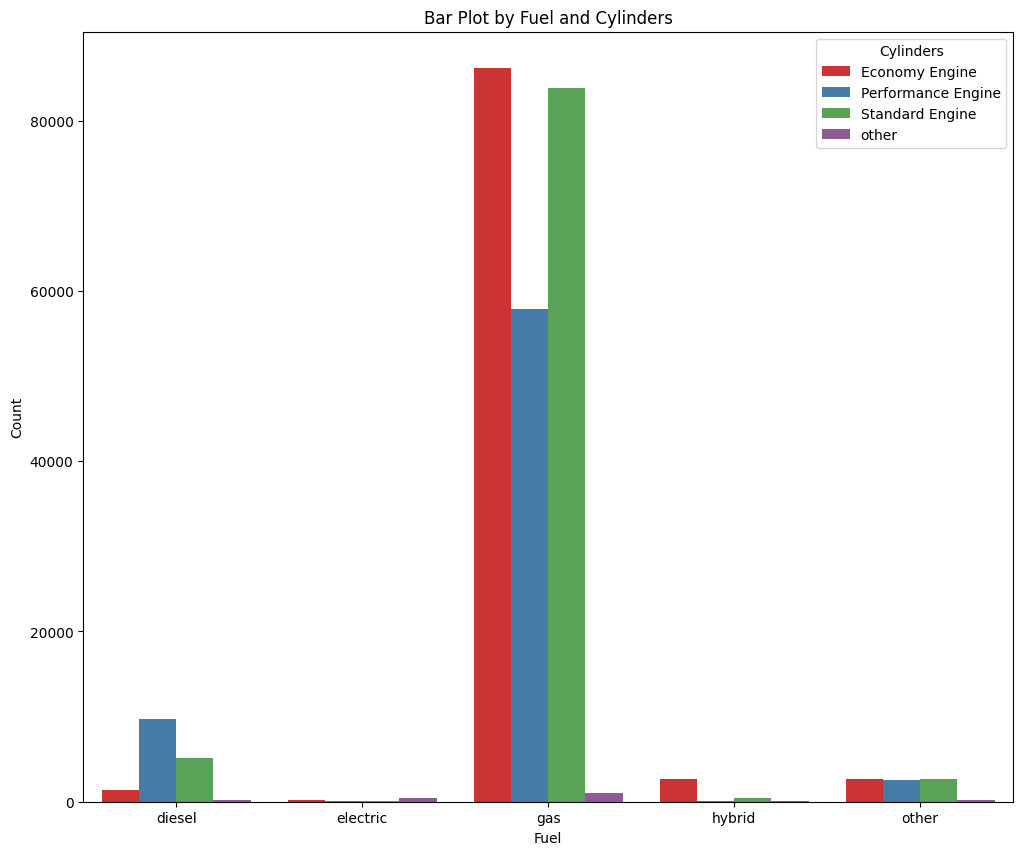

In [104]:
grouped_df = car_value.groupby(['fuel', 'cylinders']).size().unstack().fillna(0)

# Convert the grouped DataFrame to long format for Seaborn
long_df = grouped_df.reset_index().melt(id_vars='fuel', var_name='cylinders', value_name='count')

# Create a stacked bar plot with Seaborn
plt.figure(figsize=(12, 10))
sns.barplot(data=long_df, x='fuel', y='count', hue='cylinders', estimator=sum, palette='Set1')

plt.legend(title='Cylinders')
plt.xlabel('Fuel')
plt.ylabel('Count')
plt.title('Bar Plot by Fuel and Cylinders')
plt.show()
#car_value.query('fuel !="gas"').groupby(['fuel','cylinders']).size().unstack().plot.bar(stacked=True, figsize=(12, 10))

In [105]:
# Consolidate the cylinder field in to a broader category
car_value['cylinders'].replace(['3 cylinders','4 cylinders'], 'Economy Engine', inplace=True)
car_value['cylinders'].replace(['5 cylinders','6 cylinders'], 'Standard Engine', inplace=True)
car_value['cylinders'].replace(['8 cylinders','10 cylinders','12 cylinders'], 'Performance Engine', inplace=True)

In [106]:
#figsize =(10,15)
#fig = px.bar((car_value.query('title_status != "clean"').groupby("title_status")['price'].sum()).reset_index(), x="title_status", y="price")

#fig.show()

In [107]:
# Since the title_status of 'missing' and 'parts only' do not amount to much revenue we can drop them, same with the condition of salvage
car_value = car_value.drop(car_value[car_value['title_status'] == 'parts only'].index)
car_value = car_value.drop(car_value[car_value['title_status'] == 'missing'].index)
car_value = car_value.drop(car_value[car_value['condition'] == 'salvage'].index)

## Apply LabelEncoder and OneHotEncoder to the data
Do not want to run the encoding in the pipeline as the data is large and it is taking time to fit the model. Doing this step once here

In [108]:
cols_to_encode = ['manufacturer', 'state', 'paint_color' ]

# Create a LabelEncoder object for each column
encoders = {}
for col in cols_to_encode:
    encoders[col] = LabelEncoder()
    car_value[col] = encoders[col].fit_transform(car_value[col])

In [109]:
# Define columns to apply OneHotEncoder
categorical_columns = ['condition', 'cylinders','fuel','title_status', 'transmission', 'type', 'drive', 'size']

# Define the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Define the ColumnTransformer to apply OneHotEncoder only to the specified columns
column_transformer = ColumnTransformer(
    transformers=[
        ('onehot', encoder, categorical_columns)  # Apply OneHotEncoder to 'color' and 'size'
    ],
    remainder='passthrough'  # Keep other columns ('price') unchanged
)

# Fit and transform the data
transformed_data = column_transformer.fit_transform(car_value)

# Convert the result back to a DataFrame for easier inspection
encoded_car_value = pd.DataFrame(transformed_data, columns=column_transformer.get_feature_names_out())


# Modeling

In [110]:
models_df = pd.DataFrame(columns =['Model','Train MSE', 'Test MSE'])

### Functions to plot permulation importance and Feature Coefficients

In [111]:
def permutation_imp_plot(model, X, y):
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42)

    # Create a DataFrame to display importance
    importance_df = pd.DataFrame(result.importances_mean, index=X.columns, columns=['Importance'])
    importance_df.sort_values(by='Importance', ascending=False, inplace=True)
    plt.figure(figsize=(12, 8))
    
    # Plot feature importances
    sns.barplot(x=importance_df.index, y='Importance', data=importance_df, palette='viridis')
    plt.title('Feature Importance via Permutation')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [112]:
def feature_coef_plot(coefs_df):
    plt.figure(figsize=(15, 15))

    # Create a bar plot using seaborn
    sns.barplot(data=coefs_df, x='Feature', y='Coefficient', palette=['Aqua','Coral','gray','red', 'green', 'blue', 'orange','pink', 'purple','beige','yellow'])

    # Adding labels to the bars
    for index, value in enumerate(coefs_df['Coefficient']):
        plt.text(index, value, f'{coefs_df["Coefficient"][index]:.2f}', ha='center', va='bottom')

    # Optional: Adjust the rotation and layout for better readability
    plt.xticks(rotation=90)
    plt.title('Feature Coefficients')
    plt.xlabel('Features')
    plt.ylabel('Coefficient Value')

    plt.tight_layout()
    plt.show()

## Scale the data
Due to the volume of the data, do not want to run this in a pipeline. Doing this step once here

In [ ]:
scaled_car_value = (encoded_car_value-encoded_car_value.mean())/encoded_car_value.std()

## PCA Analysis

pca1 = PCA(random_state=42)
pca1.fit(scaled_car_value)
plt.figure()
plt.plot(range(1, len(pca1.explained_variance_ratio_) + 1), 
         np.cumsum(pca1.explained_variance_ratio_), '--ob')
plt.xlabel('# of Principal Components')
plt.ylabel('Cumulative Proportion')
plt.axhline(y=0.9, linestyle='dashed', color='red')
plt.axhline(y=0.8, linestyle='dashed', color='red')
plt.grid(True)
plt.title('Cumulative Variance Explained')
plt.show()

### Interpretations
1. To achieve 80% of data coverage we need to consider atleast 21 features 

## Split the Data in to 70:30 for Train and Test

In [33]:
X = scaled_car_value.drop(columns=['remainder__price'])
y = scaled_car_value['remainder__price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

## Running independent Feature Selection using Linear Regression and the Lasso()
Running this once and using the output for fitting the model. The features identified here are most important/relevant for predicting the price. The SFS based on LinearRegression seems like it encompasses all the relevant datapoints

sfs = SequentialFeatureSelector(LinearRegression())
sfs.fit(X_train, y_train)
selected_features = sfs.get_support(indices=True)
feature_names = X_train.columns[selected_features]
print(feature_names)

sfs_lasso = SequentialFeatureSelector(Lasso(random_state=42))
sfs_lasso.fit(X_train, y_train)
selected_features_lasso = sfs_lasso.get_support(indices=True)
feature_names_lasso = X_train.columns[selected_features_lasso]
print(feature_names_lasso)

## Baselining the Train and Test data MSE

baseline_train = np.ones(shape=y_train.shape)*y_train.mean()
baseline_test = np.ones(shape=y_test.shape)*y_test.mean()

mse_baseline_train = mean_squared_error(baseline_train,y_train)
mse_baseline_test = mean_squared_error(baseline_test,y_test)
print(mse_baseline_train,mse_baseline_test )

In [34]:
#0.9940010091567311 1.0139822916727175 - capturing here so I don'thave to run the code again

## Exploring Linear Regression Model

In [35]:
selected_feature_names =['onehot__condition_excellent', 'onehot__condition_fair',
       'onehot__condition_good', 'onehot__condition_like new',
       'onehot__cylinders_Economy Engine',
       'onehot__cylinders_Performance Engine', 'onehot__fuel_diesel',
       'onehot__fuel_gas', 'onehot__title_status_rebuilt',
       'onehot__title_status_salvage', 'onehot__transmission_automatic',
       'onehot__transmission_manual', 'onehot__type_Sporty_Cars',
       'onehot__type_Utility_Vehicle', 'onehot__type_other',
       'onehot__drive_fwd', 'remainder__year', 'remainder__odometer',
       'remainder__state']
lr_model = LinearRegression().fit(X_train[selected_feature_names], y_train)
train_preds = lr_model.predict(X_train[selected_feature_names])
test_preds = lr_model.predict(X_test[selected_feature_names])
lr_train_mse = mean_squared_error(y_train,train_preds )
lr_test_mse =  mean_squared_error(y_test,test_preds )

In [36]:
coefs = lr_model.coef_
print(lr_train_mse,lr_test_mse)
print(coefs)

0.6981956524779709 0.7145039298300471
[-0.32108491 -0.30535426 -0.36589613 -0.12075282 -0.08335385  0.15717536
  0.13081304 -0.07015074 -0.02224896 -0.0339752  -0.19299987 -0.09618088
  0.06478739  0.03109599  0.03045511 -0.18177847  0.29802723 -0.11100379
 -0.04467857]


In [37]:
coefs_array = np.array(coefs)  # Convert to array if necessary
# Create a DataFrame with feature names and coefficients
coefs_df = pd.DataFrame({'Feature': selected_feature_names, 'Coefficient': coefs_array})
models_df = models_df._append({'Model':'Linear Regression','Train MSE':lr_train_mse,'Test MSE':lr_test_mse }, ignore_index=True)

In [38]:
models_df

,Model,Train MSE,Test MSE
0,Linear Regression,0.698196,0.714504


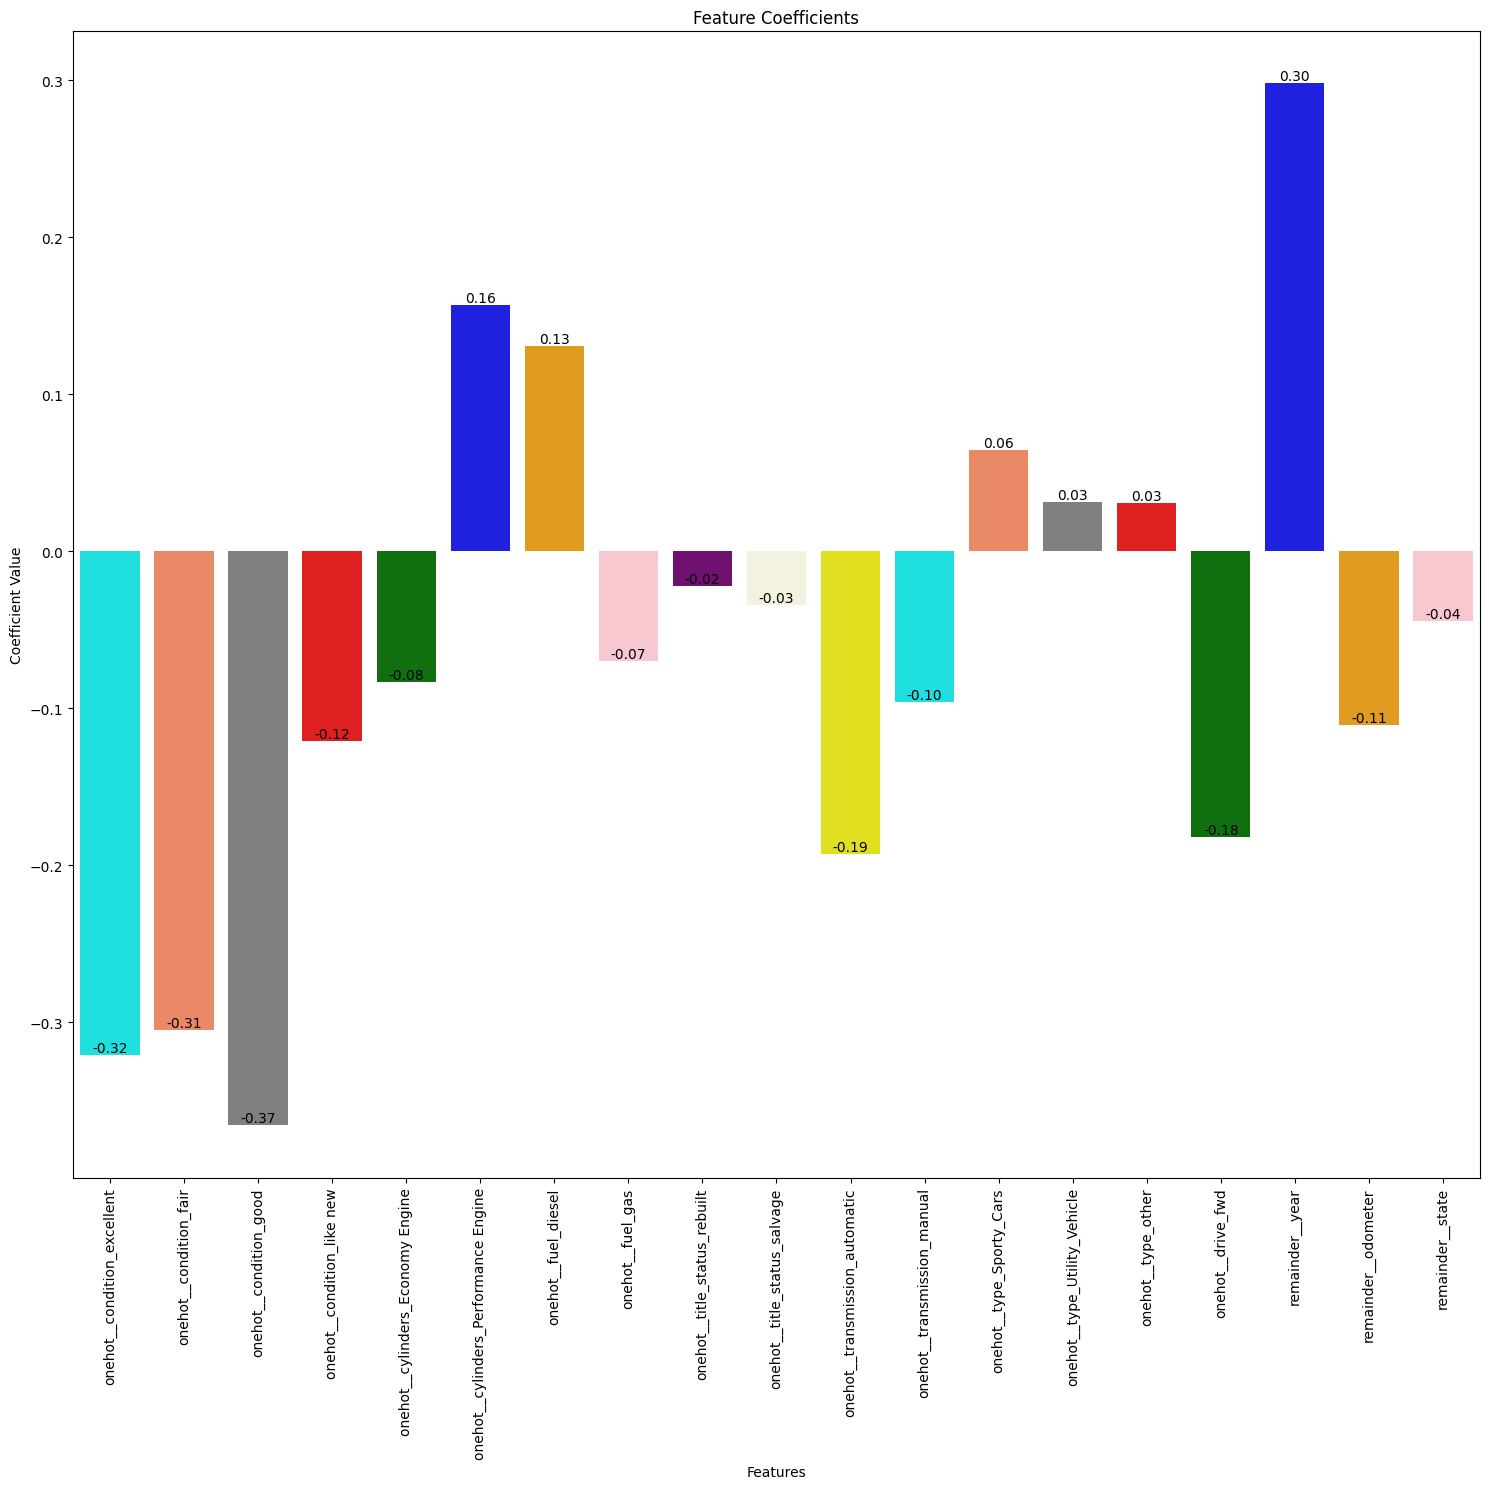

In [39]:
feature_coef_plot(coefs_df)

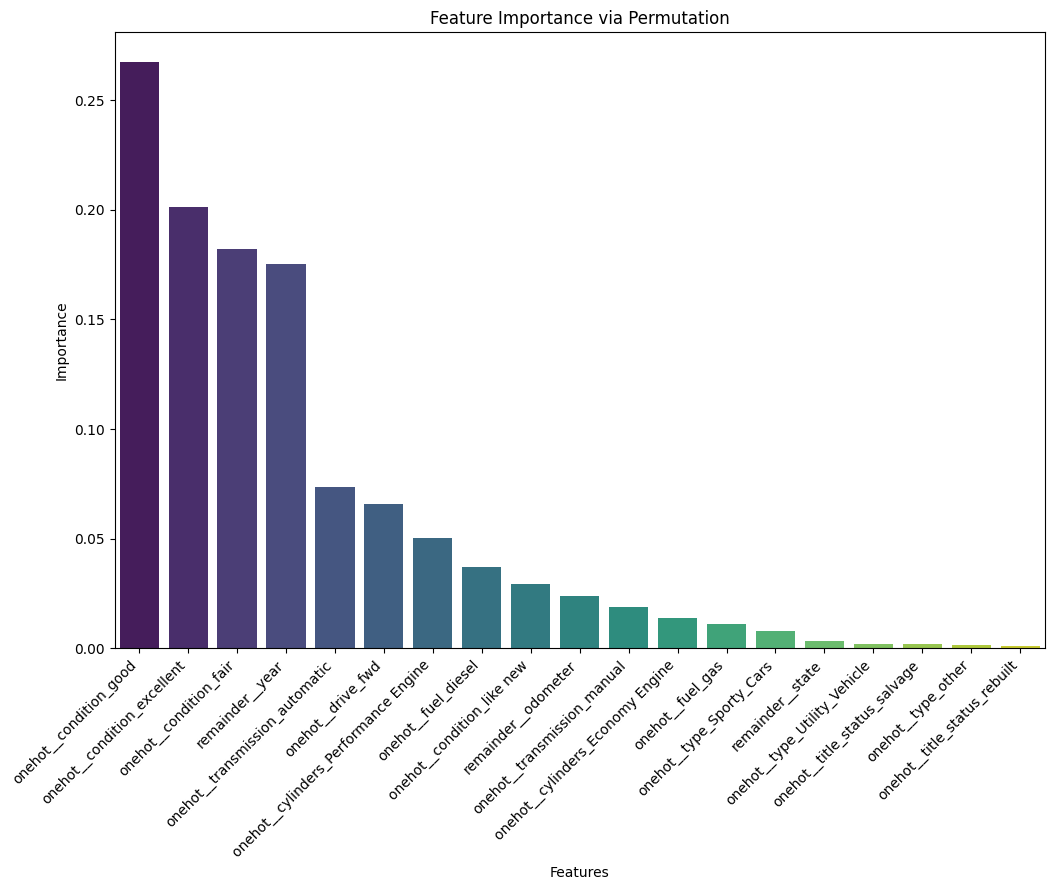

In [40]:
permutation_imp_plot(lr_model, X_test[selected_feature_names], y_test)

### Interpretation:
#### The Linear Regression model gives more importance to the condition of the car and the year it was manufactured
    

## Exploring the Ridge Model

In [57]:
param_dict = {'ridge__alpha': [0.001, 0.1, 1.0, 10.0, 100.0, 1000.0]}
pipe = Pipeline([('ridge', Ridge())])
grid = GridSearchCV(pipe, param_grid = param_dict)
grid.fit(X_train,y_train)
train_preds = grid.predict(X_train)
test_preds = grid.predict(X_test)
ridge_train_mse = mean_squared_error(y_train,train_preds)
ridge_test_mse = mean_squared_error(y_test,test_preds)
ridge_best_alpha = grid.best_params_

In [58]:
print(ridge_train_mse,ridge_test_mse )
print(ridge_best_alpha)
models_df = models_df._append({'Model':'Ridge Regression','Train MSE':ridge_train_mse,'Test MSE':ridge_test_mse }, ignore_index=True)

0.6968318438182742 0.7133154106731685
{'ridge__alpha': 100.0}


In [59]:
best_estimator = grid.best_estimator_
best_model = best_estimator.named_steps['ridge']
coefs = best_model.coef_
coefs_array = np.array(coefs)  # Convert to array if necessary
# Create a DataFrame with feature names and coefficients
coefs_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefs_array})
models_df

,Model,Train MSE,Test MSE
0,Linear Regression,0.698196,0.714504
1,Ridge Regression,0.696832,0.713315
2,Ridge Regression,0.696832,0.713315
3,Lasso Regression,0.698852,0.714661
4,Ridge Regression,0.696832,0.713315


In [60]:
coefs_df

,Feature,Coefficient
0,onehot__condition_excellent,-0.007360
1,onehot__condition_fair,0.038913
2,onehot__condition_good,-0.081341
3,onehot__condition_like new,0.057180
4,onehot__condition_new,0.044119
5,onehot__cylinders_Economy Engine,-0.102858
6,onehot__cylinders_Performance Engine,0.135220
7,onehot__cylinders_Standard Engine,-0.019664
8,onehot__cylinders_other,-0.015654
9,onehot__fuel_diesel,0.118374


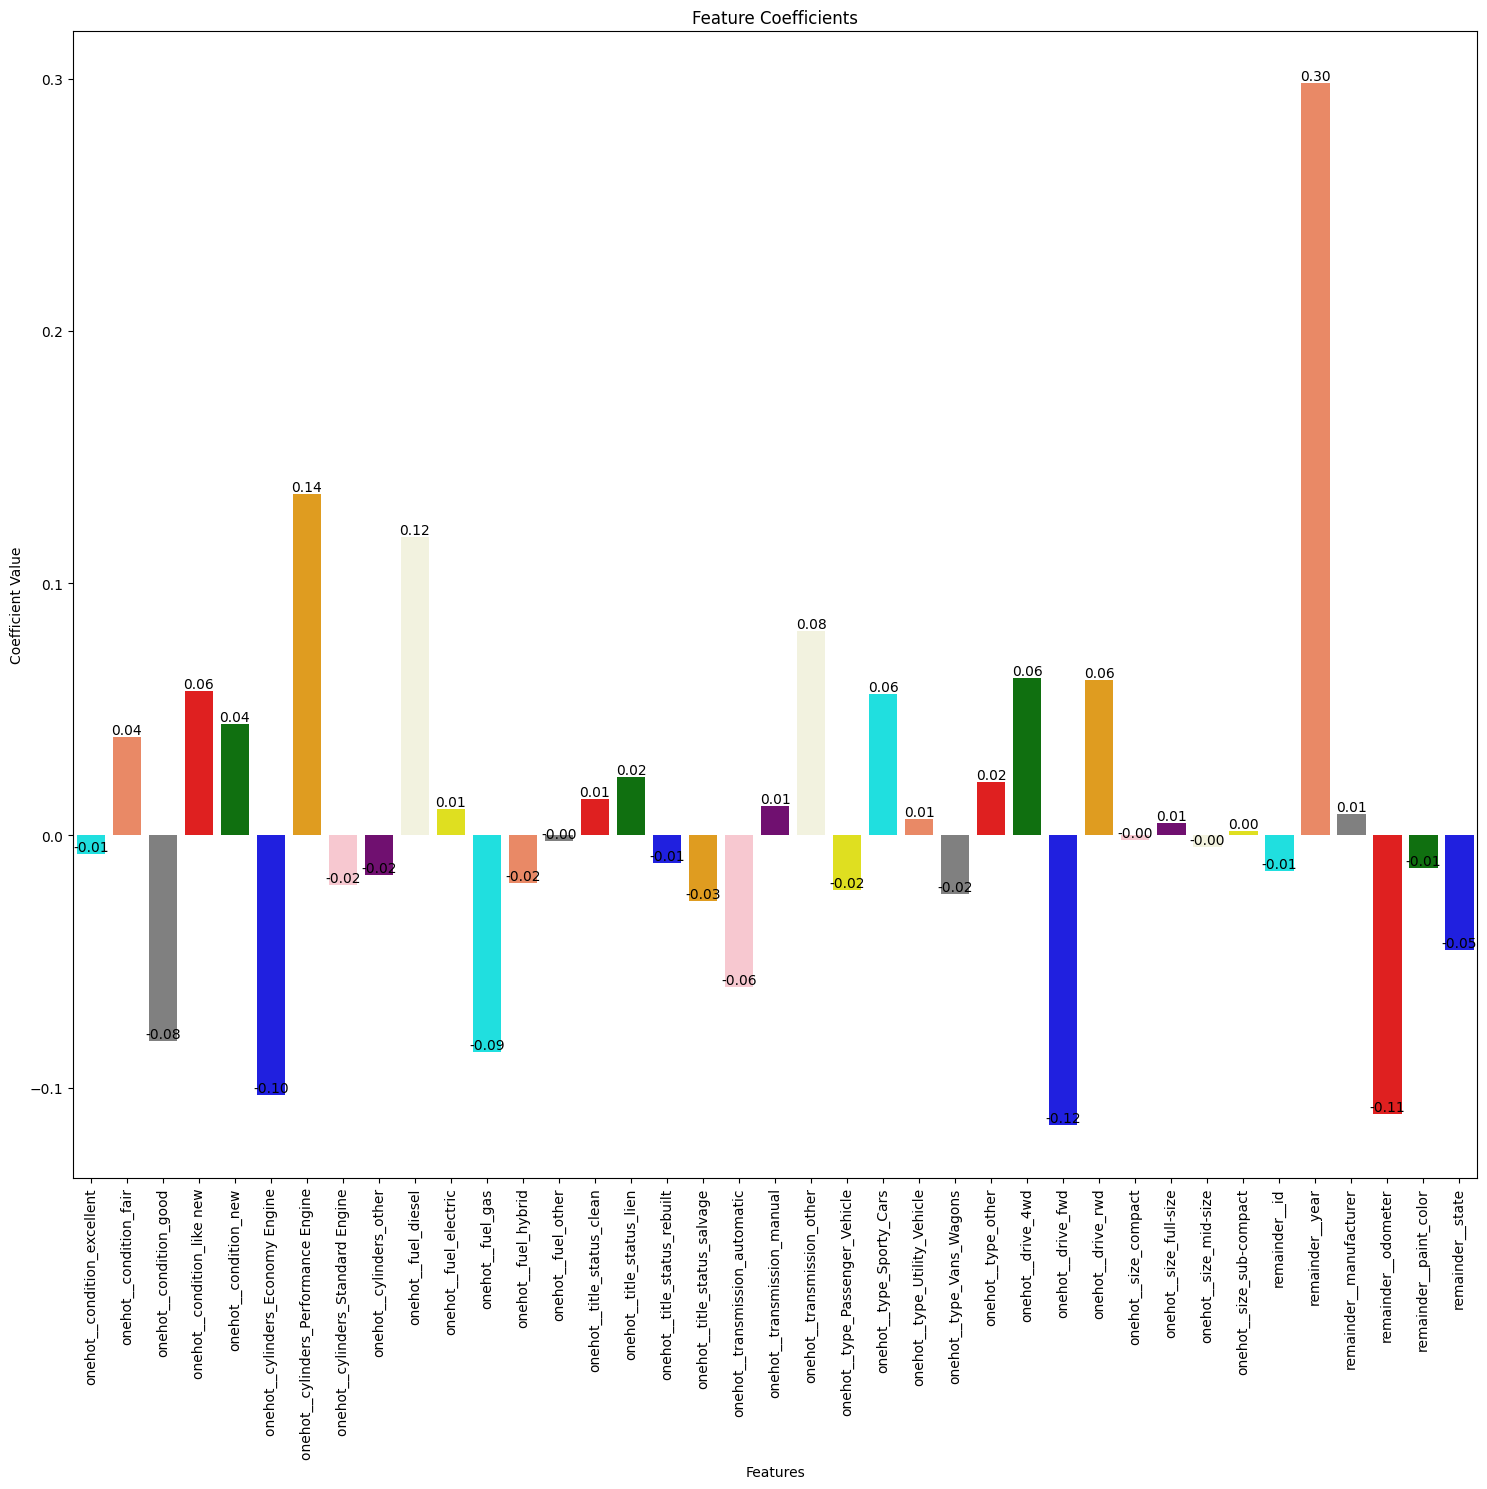

In [44]:
feature_coef_plot(coefs_df)

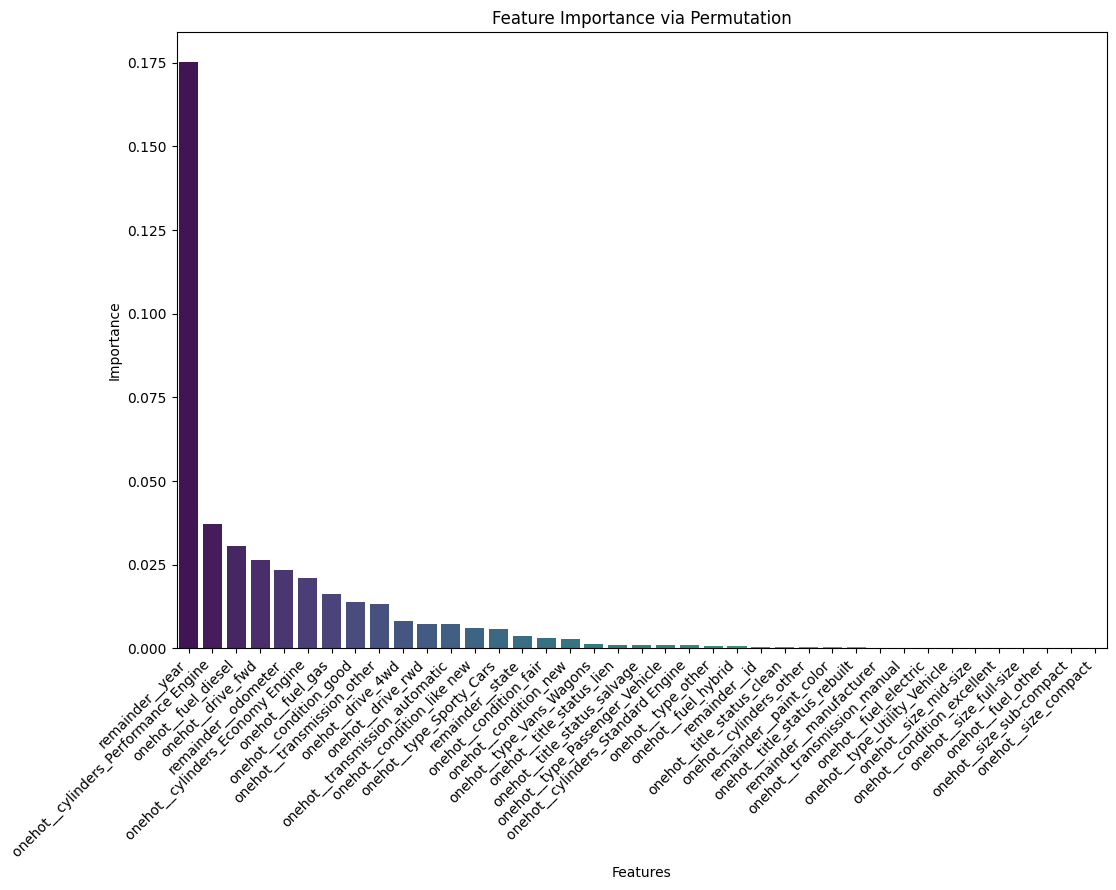

In [45]:
permutation_imp_plot(grid, X_test, y_test)

### Interpretation
#### The Test and Train MSE for the Ridge Regression model are quiet close to the Linear Regression model and considers all the features. However to note here that the Ridge Regression model gives highest importance to the manufacture year of the car so more recent the car the better price it sells for. Other factors of importance are:
#### Higher performance engines(8-12 cylinders) positively influence the price
#### Other features that yield better price are Diesel or electric vehicles, not much driven - less miles on the odometer, 4 wheel drive,  or rear wheel drive, clean or lien title status
#### Features that negatively impact the car price are, front wheel drive, hight mileage, 3 or 4 cylinder, gas vehicles, 

## Exploring the Lasso Model

In [47]:
param_dict = {'lasso__alpha': [0.001, 0.1, 1.0, 10.0, 100.0, 1000.0]}
pipe = Pipeline([('lasso', Lasso(random_state=42))])
grid_lasso = GridSearchCV(pipe, param_grid = param_dict)
grid_lasso.fit(X_train[selected_feature_names],y_train)
train_preds = grid_lasso.predict(X_train[selected_feature_names])
test_preds = grid_lasso.predict(X_test[selected_feature_names])
lasso_train_mse = mean_squared_error(y_train,train_preds)
lasso_test_mse = mean_squared_error(y_test,test_preds)
lasso_best_alpha = grid_lasso.best_params_

In [55]:
print(lasso_train_mse,lasso_test_mse )
print(lasso_best_alpha)
models_df = models_df._append({'Model':'Lasso Regression','Train MSE':lasso_train_mse,'Test MSE':lasso_test_mse }, ignore_index=True)

0.698851825888916 0.7146609963771705
{'lasso__alpha': 0.001}


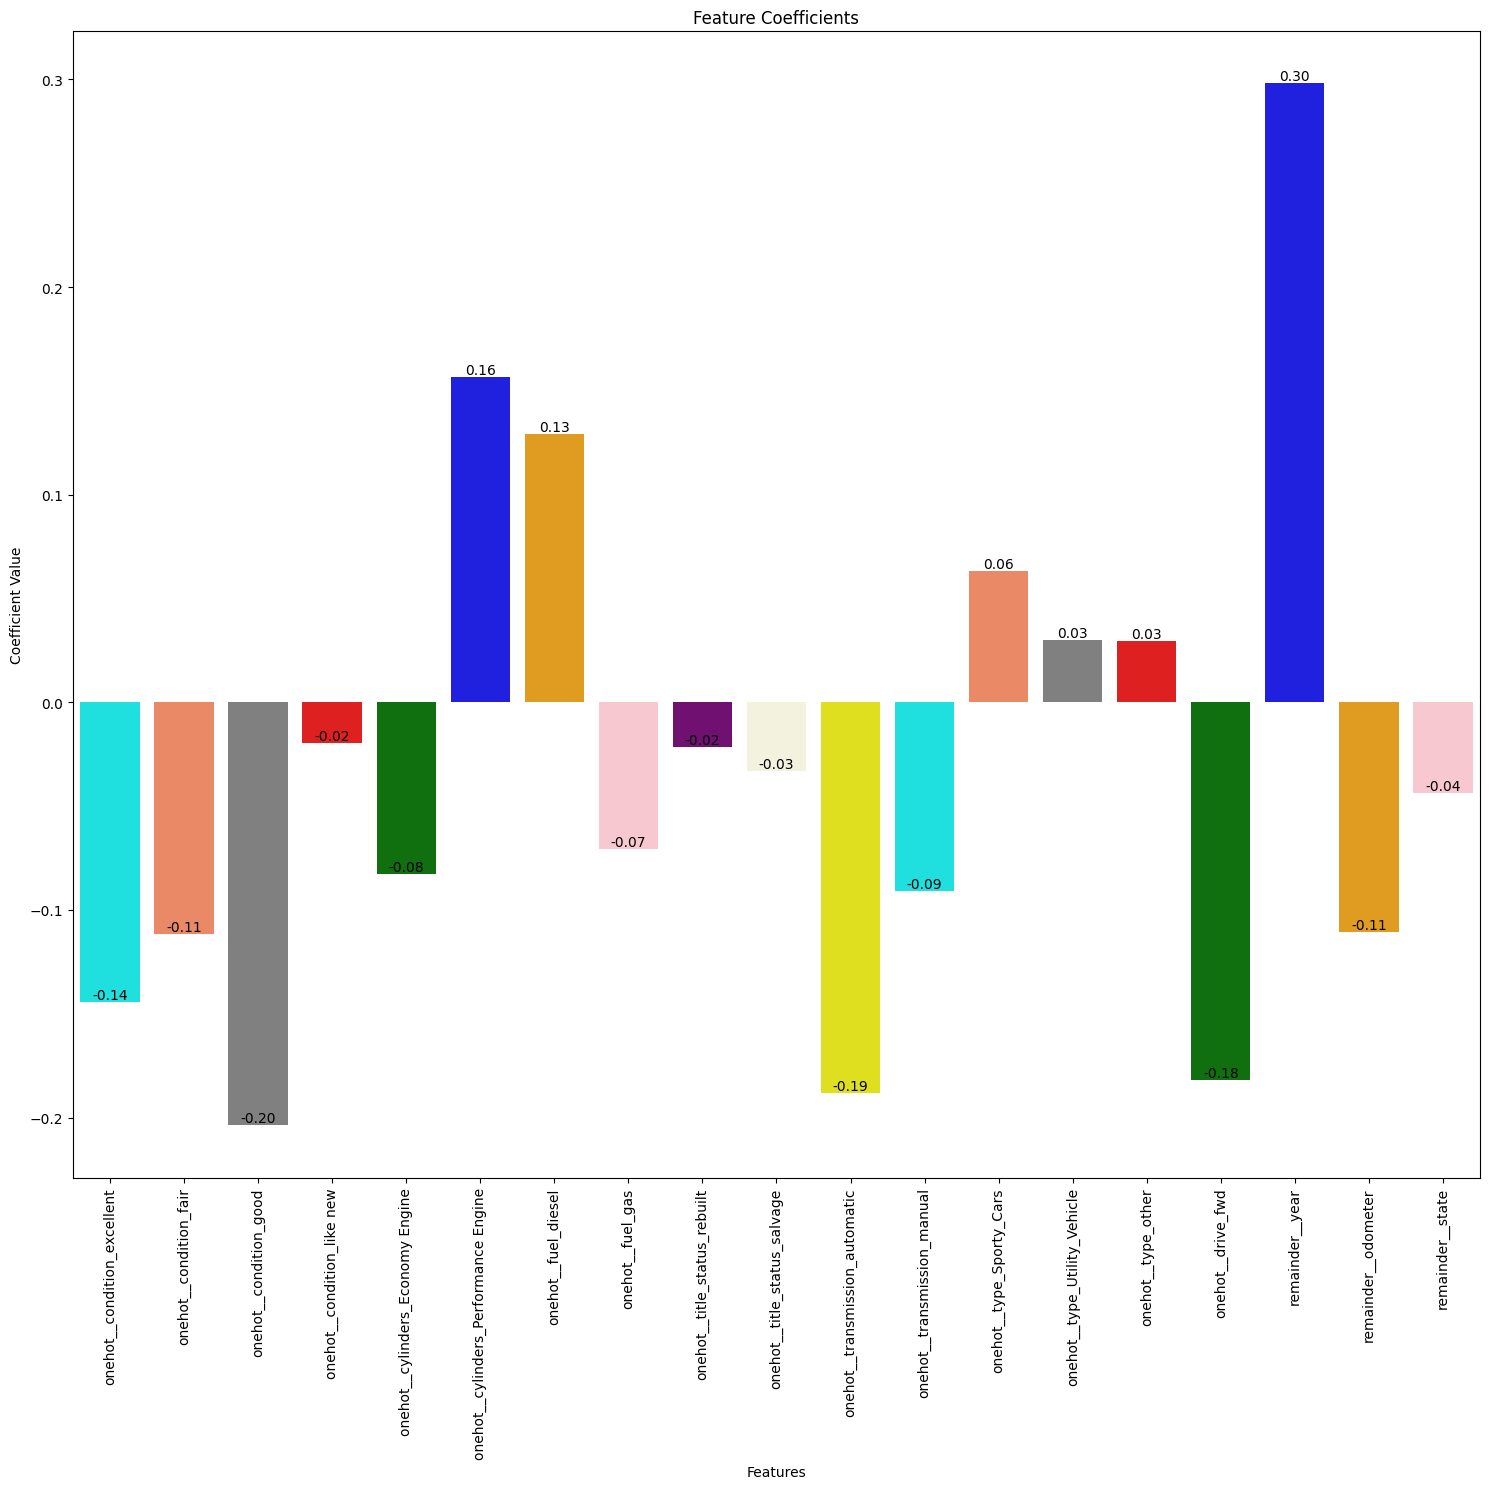

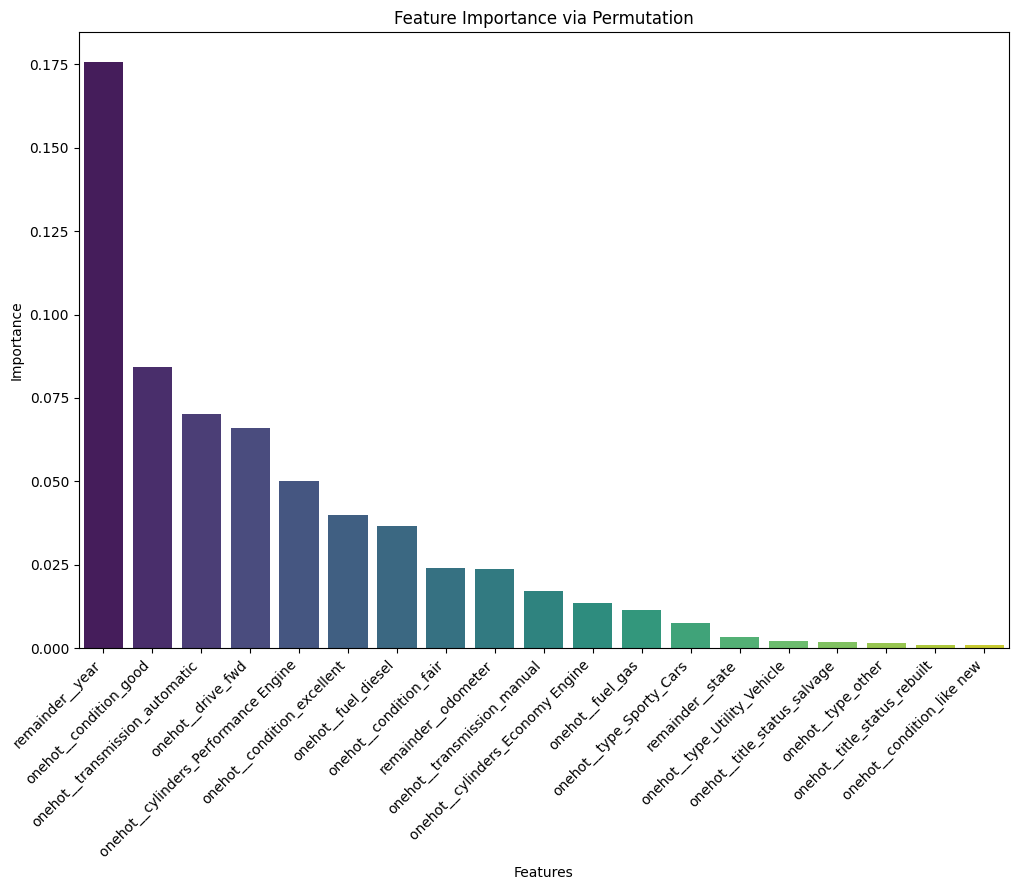

In [53]:
coefs = grid_lasso.best_estimator_.named_steps['lasso'].coef_
coefs_array = np.array(coefs)  # Convert to array if necessary
# Create a DataFrame with feature names and coefficients
coefs_df = pd.DataFrame({'Feature': selected_feature_names, 'Coefficient': coefs_array})
feature_coef_plot(coefs_df)
permutation_imp_plot(grid_lasso, X_test[selected_feature_names], y_test)

In [56]:
models_df

,Model,Train MSE,Test MSE
0,Linear Regression,0.698196,0.714504
1,Ridge Regression,0.696832,0.713315
2,Ridge Regression,0.696832,0.713315
3,Lasso Regression,0.698852,0.714661


# Conclusion

All the 3 models had almost same Train and Test MSE with Ridge Regression model performing slightly better.
The Car Dealer should stock up their store with used cars that are 
#### 1> Newer Model year
#### 2> Higher performance engines(8-12 cylinders)
#### 3> Diesel or electric vehicles, 
#### 4> Car that have less miles on the odometer, 
#### 5> 4-wheel drive, or rear wheel drive - Sporty or Utility vehicles
#### 6> Clean or lien title status¶

They should definitely stay away from 
#### 1> Cars that are 3-4 cylinders
#### 2> Cars having more mileage that indicate significate wear and tear
#### 3> Forward wheel drives
#### 4> Gas vehicles - as government policies are promoting Electric cars with rebates etc. Salvage or rebuilt title status

Factors that don't have much impact are
#### 1> Size - They can carry subcompact to Full size vehicles
#### 2> Manufacturer - They can carry cars manufactured by any company